# These are the Cartography visuals.

# To Do:
- add snakemake commands instead of explicit paths once main snakefile is updated
- add genetic KDE to full plot (create using the scripts)

# Imports Section 

In [1]:
import altair as alt
from augur.utils import json_to_tree
import json
import matplotlib.pyplot as plt
import pandas as pd
import re
#from reportlab.graphics import renderPDF
import seaborn as sns
#from svglib.svglib import svg2rlg

from Helpers import linking_tree_with_plots_clickable, linking_tree_with_plots_brush, scatterplot_with_tooltip_interactive
from Helpers import get_y_positions

%matplotlib inline

In [6]:
try: 
    snakemake.input.tree 
    import selenium
    from selenium.webdriver import Chrome 
    from selenium import webdriver

    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("--remote-debugging-port=9222")

    browser = webdriver.Chrome(options=chrome_options)
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


# Zika Specific Variables 

In [7]:
try:
    path = snakemake.input.alignment
    dropped_strains = [line.rstrip('\n') for line in open(snakemake.input.dropped_strains,"r")]
    tree_path = snakemake.input.tree
    if snakemake.input.clade_names is not None:
        clades_to_plot = [line.rstrip('\n') for line in open(snakemake.input[len(snakemake.input)-2],"r")]
    f = open(snakemake.input.disease_name, "r")
    virus_name = f.read()
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


In [7]:
#path = "../zika-nextstrain/results/aligned.fasta"
#tree_path = '../auspice/cartography_zika.json'
virus_name = "Zika"
clades_to_plot = None

# Reading in all the data from the scripts

In [8]:
import os

os.getcwd()

'/mnt/c/Work/BedfordProjects/cartography/zika-nextstrain'

In [9]:
node_df = pd.read_csv("results/table.tsv", sep="\t")

In [10]:
node_df.rename(columns={'num_date':'date', 'y_value':"y"}, inplace=True)

In [11]:
similarity_matrix = pd.read_csv("results/distance_matrix.csv", index_col=0)

In [12]:
similarity_matrix.columns = similarity_matrix.index

# Creating the Phylogenetic Tree in Altair
- I used Altair to make this tree (Documentation linked [here][1]
- The data from the JSON and the Data from the tree are usually a little different, so after merging the two dataframes you may get some errors.

[1]: https://altair-viz.github.io/index.html

In [29]:
with open(tree_path) as fh:
    json_tree_handle = json.load(fh)

In [30]:
tree = json_to_tree(json_tree_handle)

In [31]:
tree

Clade(branch_length=0, name='NODE_0000000')

In [32]:
heights = get_y_positions(tree)
for node in tree.find_clades():
    node.yvalue = heights[node]

In [33]:
node_data = [
    {
        "strain": node.name,
        "date": node.node_attrs["num_date"]["value"],
        "y": node.yvalue,
        "region": node.node_attrs["region"]["value"],
        "country": node.node_attrs["country"]["value"],
        "parent_date": node.parent is not None and node.parent.node_attrs["num_date"]["value"] or node.node_attrs["num_date"],
        "parent_y": node.parent is not None and node.parent.yvalue or node.yvalue,
        "clade_membership" : node.node_attrs['clade_membership']["value"]
    }
    for node in tree.find_clades(terminal=True)
]

In [34]:
node_data[10]

{'strain': 'SG_018',
 'date': 2016.700819672131,
 'y': 11,
 'region': 'southeast_asia',
 'country': 'singapore',
 'parent_date': 2015.890474324395,
 'parent_y': 10.5,
 'clade_membership': 'c2'}

In [35]:
node_df = pd.DataFrame(node_data)

In [36]:
node_df.head()

strain         date  y          region    country  parent_date  \
0              SG_021  2016.700820  1  southeast_asia  singapore  2011.617113   
1            SI_BKK06  2017.683562  2  southeast_asia   thailand  2011.617113   
2               BKK07  2017.749315  3  southeast_asia   thailand  2014.548672   
3   Thailand/1610acTw  2016.831967  4  southeast_asia   thailand  2014.944100   
4  Thai/KngSG/17_D501  2017.909871  5  southeast_asia   thailand  2015.730359   

   parent_y clade_membership  
0   1.50000       unassigned  
1   1.50000       unassigned  
2   3.96875               c2  
3   4.93750               c2  
4   5.87500               c2

In [37]:
node_df["y"] = node_df["y"].max() - node_df["y"]

In [38]:
node_df["parent_y"] = node_df["parent_y"].max() - node_df["parent_y"]

In [39]:
node_df.shape

(674, 8)

In [13]:
node_df.head()

strain     date  pca1  pca2   mds1   mds2  tsne_x  tsne_y  \
0              SG_021  2016.70  4.98 -0.16 -52.90   3.24   30.09   23.79   
1            SI_BKK06  2017.68  2.86 -0.07 -12.01   1.76   32.29   16.46   
2               BKK07  2017.75  6.89 -0.05 -19.32  16.01   38.24   21.16   
3   Thailand/1610acTw  2016.83  7.03  0.01  -4.94  16.25   32.30   18.29   
4  Thai/KngSG/17_D501  2017.88  6.95  0.01  11.24  -6.68   27.38   19.75   

   umap_x  umap_y clade_membership  y  
0   16.50   12.55       unassigned  1  
1   16.61   11.97       unassigned  2  
2   17.02   12.09               c2  3  
3   17.14   12.27               c2  4  
4   17.21   12.10               c2  5

In [41]:
node_df["region"].unique()

array(['southeast_asia', 'oceania', 'china', 'south_america',
       'north_america', 'africa', 'japan_korea'], dtype=object)

In [14]:
# Reannotate clades that we aren't interested in as "other" to simplify color assignment in visualizations.
try:
    node_df["clade_membership_color"] = node_df["clade_membership"].apply(lambda clade: clade if clade in clades_to_plot else "other")
except:
    node_df["clade_membership_color"] = node_df["clade_membership"]
    print("clades_to_plot undefined")

clades_to_plot undefined


In [15]:
indices_to_drop = similarity_matrix[~similarity_matrix.index.isin(node_df["strain"])].dropna(how = 'all')
similarity_matrix = similarity_matrix[similarity_matrix.index.isin(node_df["strain"])].dropna(how = 'all')
similarity_matrix = similarity_matrix.drop(indices_to_drop.index, axis=1)
similarity_matrix

FrenchPolynesia2014_060114_016  1_0049_PF  \
FrenchPolynesia2014_060114_016                               0         15   
1_0049_PF                                                   15          0   
1_0030_PF                                                   14         13   
1_0035_PF                                                   15         14   
1_0087_PF                                                   12         11   
...                                                        ...        ...   
MEX/2016/mex45                                              29         24   
Bahia15                                                     19         14   
NIC/5847_12B1/2016                                          28         23   
USA/2016/FLUR005                                            32         27   
USA/2016/FLUR001                                            30         25   

                                1_0030_PF  1_0035_PF  1_0087_PF  1_0181_PF  \
FrenchPolynesia2014_060114_016         14         15         12         11   
1_0049_PF                              13         14         11         10   
1_0030_PF                               0         11          8          9   
1_0035_PF                              11          0          7         10   
1_0087_PF                               8          7          0          7   
...                                   ...        ...        ...        ...   
MEX/2016/mex45                         29         30         27         26   
Bahia15                                19         20         17         16   
NIC/5847_12B1/2016                     28         29         26         25   
USA/2016/FLUR005                       32         33         30         29   
USA/2016/FLUR001                       30         31         28         27   

                                1_0015_PF  H/PF/2013  TS17_2016  1_0199_PF  \
FrenchPolynesia2014_060114_016         14         13         25         11   
1_0049_PF                              13         12         24         10   
1_0030_PF                              12          9         21         11   
1_0035_PF                              13          8         22         12   
1_0087_PF                              10          5         19          9   
...                                   ...        ...        ...        ...   
MEX/2016/mex45                         29         27         40         22   
Bahia15                                19         17         30         12   
NIC/5847_12B1/2016                     28         26         39         21   
USA/2016/FLUR005                       32         30         43         25   
USA/2016/FLUR001                       30         26         41         23   

                                ...  MEX/2016/mex04  USA/2016/FL029  \
FrenchPolynesia2014_060114_016  ...              31              29   
1_0049_PF                       ...              26              24   
1_0030_PF                       ...              31              29   
1_0035_PF                       ...              32              30   
1_0087_PF                       ...              29              27   
...                             ...             ...             ...   
MEX/2016/mex45                  ...              30              32   
Bahia15                         ...              24              22   
NIC/5847_12B1/2016              ...              21              31   
USA/2016/FLUR005                ...              37              19   
USA/2016/FLUR001                ...              35              17   

                                COL/2016/SU_2293A  MEX/2016/mex38  \
FrenchPolynesia2014_060114_016                 23              28   
1_0049_PF                                      18              23   
1_0030_PF                                      23              26   
1_0035_PF                                      24              29   
1_0087_PF                          

In [16]:
node_df

strain     date  pca1  pca2   mds1   mds2  tsne_x  \
0                    SG_021  2016.70  4.98 -0.16 -52.90   3.24   30.09   
1                  SI_BKK06  2017.68  2.86 -0.07 -12.01   1.76   32.29   
2                     BKK07  2017.75  6.89 -0.05 -19.32  16.01   38.24   
3         Thailand/1610acTw  2016.83  7.03  0.01  -4.94  16.25   32.30   
4        Thai/KngSG/17_D501  2017.88  6.95  0.01  11.24  -6.68   27.38   
..                      ...      ...   ...   ...    ...    ...     ...   
669  MEX/41_001_F_V7_O/2016  2016.49 -2.03 -1.91  -0.80  -3.83   19.29   
670  MEX/41_001_F_V3_O/2016  2016.48 -2.03 -1.91   1.57  -1.67   19.32   
671  MEX/41_017_F_V7_O/2016  2016.62 -1.92 -1.86  -4.88  -6.00   16.38   
672  MEX/41_017_F_V0_O/2016  2016.60 -1.92 -1.85  -4.94  -4.05   16.41   
673  MEX/41_017_F_V3_O/2016  2016.61 -1.93 -1.92  -5.39  -5.87   16.37   

     tsne_y  umap_x  umap_y clade_membership    y clade_membership_color  
0     23.79   16.50   12.55       unassigned    1             unassigned  
1     16.46   16.61   11.97       unassigned    2             unassigned  
2     21.16   17.02   12.09               c2    3                     c2  
3     18.29   17.14   12.27               c2    4                     c2  
4     19.75   17.21   12.10               c2    5                     c2  
..      ...     ...     ...              ...  ...                    ...  
669   -7.31    8.88   10.37               c4  670                     c4  
670   -7.31    8.66    9.94               c4  671                     c4  
671   -7.93    8.49   11.61               c4  672                     c4  
672   -7.88    8.51   11.72               c4  673                     c4  
673   -7.92    8.38   11.51               c4  674                     c4  

[674 rows x 13 columns]

# Running PCA on Scaled and Centered Data
- I treated each nucleotide as a "site", or dimension, and found the probability of having a certain nucleotide given the frequency of that letter at that site.
- I used [this paper][1] as my source 
- The equation is as follows where C is the matrix of dimensions, M is the mean, and p is the frequency of a nucleotide at that given site. 
![](https://journals.plos.org/plosgenetics/article/file?type=thumbnail&id=info:doi/10.1371/journal.pgen.0020190.e003)

In [27]:
#principalDf = pd.read_csv(snakemake.input.pca)
principalDf = pd.read_csv("results/embed_pca.csv", index_col=0)

In [28]:
#explained_variance_df = pd.read_csv(snakemake.input.pca + "explained_variance")
explained_variance_df = pd.read_csv("results/explained_variance_pca.csv")
explained_variance_df

explained variance  principal components
0              0.3303                     0
1              0.0668                     1
2              0.0582                     2
3              0.0410                     3
4              0.0278                     4
5              0.0181                     5
6              0.0137                     6
7              0.0127                     7
8              0.0100                     8
9              0.0085                     9

In [29]:
chart = alt.Chart(explained_variance_df).mark_line().encode(
    x='principal components:Q',
    y='explained variance:Q'
)
chart

alt.Chart(...)

In [30]:
merged_pca_df = principalDf.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [31]:
merged_pca_df.head()

strain      pca1      pca2      pca3      pca4  \
0  FrenchPolynesia2014_060114_016 -0.997941 -0.175648 -0.003561  0.365233   
1                       1_0049_PF -1.198016 -0.181179  0.006347  0.365003   
2                       1_0030_PF -0.799273 -0.188163 -0.026013  0.406214   
3                       1_0035_PF -0.796212 -0.176426 -0.004482  0.416134   
4                       1_0087_PF -0.795955 -0.176493 -0.005463  0.409790   

       pca5      pca6      pca7      pca8      pca9     pca10  pca_label  \
0  1.466314  0.385359  0.106724 -0.499462 -0.059383  0.102441          7   
1  1.150645  0.555289  0.123734 -0.541795 -0.060750  0.063962          7   
2  1.691945  0.217905  0.095011 -0.474991 -0.058493  0.122324         -1   
3  1.674878  0.219091 -0.004162 -0.479464 -0.052152  0.129361         -1   
4  1.671313  0.223653  0.093968 -0.450863 -0.052804  0.124998         -1   

      date    y clade_membership clade_membership_color  
0  2014.02  153               c1                     c1  
1  2014.00  159               c1                     c1  
2  2013.91  129               c1                     c1  
3  2014.08  130               c1                     c1  
4  2014.00  133               c1                     c1

In [32]:
explained_variance_PCA = explained_variance_df["explained variance"].values.tolist()

In [34]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "clade_membership:N",['strain', "clade_membership"])
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.HConcatChart(...)

# HDBSCAN Output

In [35]:
list_of_chart = linking_tree_with_plots_clickable(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "pca_label:N",["pca_label"], ['strain'])
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[4]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.HConcatChart(...)

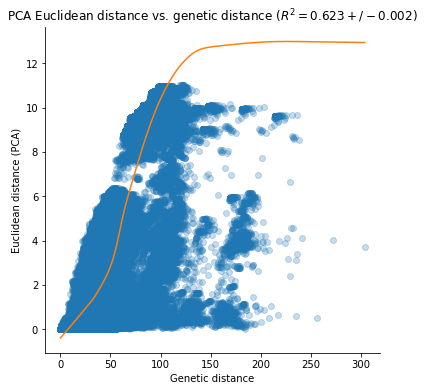

In [14]:
#total_df = pd.read_csv(snakemake.input.pca.replace(".csv", "") + "scatterplot.csv", index_col=0)
total_df_PCA = pd.read_csv("results/scatterplot_pca.csv",index_col=0)
metadata_PCA = pd.read_csv("results/scatterplot_pca_metadata.csv", index_col=0)

mean = metadata_PCA["mean"].values.tolist()[0]
std = metadata_PCA["std"].values.tolist()[0]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (PCA)")
ax.set_title(f"PCA Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

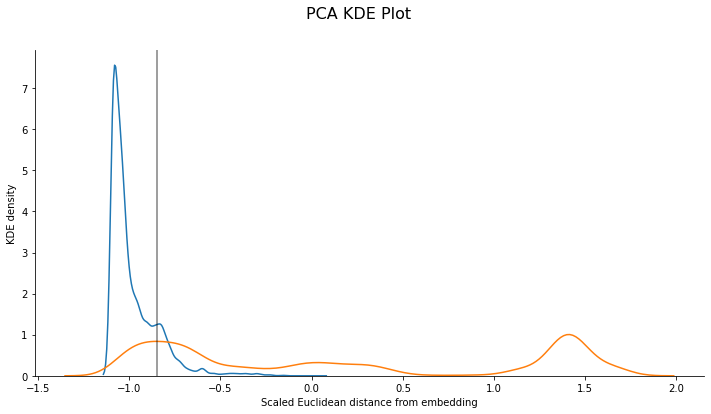

In [21]:
PCA_KDE_df = pd.read_csv("results/KDEDensity_pca.csv",index_col=0)
PCA_KDE_metadata_df = pd.read_csv("results/KDEDensity_pca_metadata.csv", index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=PCA_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('PCA KDE Plot', fontsize=16)
sns.despine()

# Running MDS on the Dataset

In [41]:
#principalDf = pd.read_csv(snakemake.input.pca)
MDS_df = pd.read_csv("results/embed_mds.csv",index_col=0)

In [42]:
merged_mds_df = MDS_df.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [43]:
merged_mds_df

strain      mds1       mds2      mds3       mds4  \
0    FrenchPolynesia2014_060114_016  0.588190  10.081880  2.750612  -2.912229   
1                         1_0049_PF  0.501479   2.927546 -0.574679  -1.142493   
2                         1_0030_PF -1.771414   7.614729  3.721486  -0.476082   
3                         1_0035_PF -1.635523   8.476416  5.309207  -0.977201   
4                         1_0087_PF -0.989982   4.894049  2.767018  -0.333255   
..                              ...       ...        ...       ...        ...   
669                  MEX/2016/mex45 -8.126242   3.485095 -6.098505   0.048483   
670                         Bahia15  0.948342   1.950383 -6.126530  -2.481158   
671              NIC/5847_12B1/2016 -0.067771  -4.746417 -4.413497  -1.897384   
672                USA/2016/FLUR005  5.965042   1.669733 -1.261019 -17.794795   
673                USA/2016/FLUR001  6.731704   1.299242 -3.831259 -16.438819   

         mds5      mds6       mds7       mds8       mds9      mds10  \
0    5.647079 -1.358978  -0.406870  -0.994742   0.071649   1.967933   
1    2.258386 -0.814397  -1.058553   1.399575   0.257606   1.601833   
2    2.793884 -0.183845  -0.645874  -1.494372   2.624752   2.575180   
3    4.871411 -0.769423  -0.548049  -1.078307   2.540324   3.147800   
4    2.440866 -0.087515   0.399654  -1.325221   1.599394   1.233413   
..        ...       ...        ...        ...        ...        ...   
669 -5.170166 -9.910444  -8.863137   8.665223   5.513321  14.371412   
670  0.925066 -3.230039  -0.886664   3.340356  -2.562022   3.688779   
671  1.809930 -3.870107 -16.346092   3.520259 -10.457442  -4.119209   
672 -6.782300  3.615036   5.094153  16.898014  -3.974358   7.102155   
673 -4.000215  1.038052   8.419241  14.326287  -5.127924   2.211325   

     mds_label     date    y clade_membership clade_membership_color  
0            1  2014.02  153               c1                     c1  
1            1  2014.00  159               c1                     c1  
2            1  2013.91  129               c1                     c1  
3            1  2014.08  130               c1                     c1  
4            1  2014.00  133               c1                     c1  
..         ...      ...  ...              ...                    ...  
669          1  2016.50  585               c4                     c4  
670          1  2016.00  169               c3                     c3  
671          1  2016.10  620               c4                     c4  
672          1  2016.58  433               c5                     c5  
673          1  2016.57  441               c5                     c5  

[674 rows x 16 columns]

In [44]:
chart_12_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain','clade_membership'],'clade_membership:N')
chart_34_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds3','mds4',"mds3","mds4",['strain','clade_membership'],'clade_membership_color')
chart_56_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds5','mds6',"mds5","mds6",['strain','clade_membership'],'clade_membership_color')
chart_12_mds|chart_34_mds|chart_56_mds

alt.HConcatChart(...)

In [45]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'clade_membership:N', ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]

alt.HConcatChart(...)

# HDBSCAN output:

In [46]:
list_of_chart = linking_tree_with_plots_clickable(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'mds_label:N', ["mds_label"], ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

alt.HConcatChart(...)

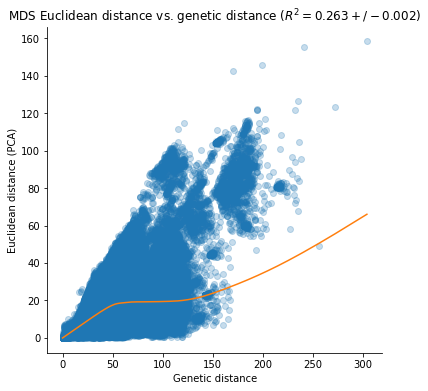

In [7]:
#total_df = pd.read_csv(snakemake.input.pca.replace(".csv", "") + "scatterplot.csv", index_col=0)
total_df_MDS = pd.read_csv("results/scatterplot_mds.csv",index_col=0)
metadata_MDS = pd.read_csv("results/scatterplot_mds_metadata.csv", index_col=0)

mean = metadata_MDS["mean"].values.tolist()[0]
std = metadata_MDS["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (MDS)")
ax.set_title(f"MDS Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

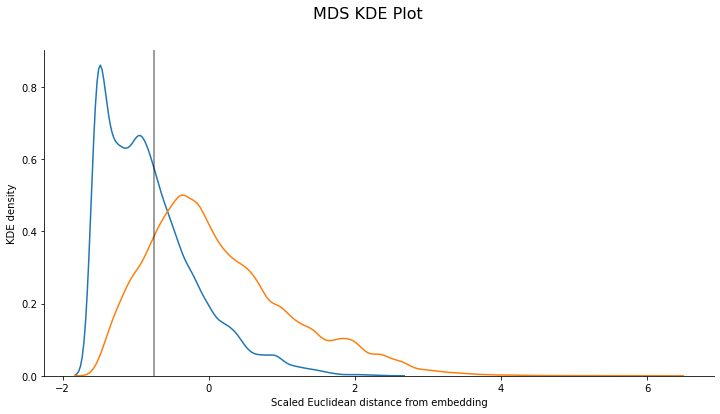

In [22]:
MDS_KDE_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_mds.csv",index_col=0)
MDS_KDE_metadata_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_mds_metadata.csv", index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=MDS_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('MDS KDE Plot', fontsize=16)
sns.despine()

# Running T-SNE on the Dataset 

In [53]:
#principalDf = pd.read_csv(snakemake.input.pca)
TSNE_df = pd.read_csv("results/embed_t-sne.csv",index_col=0)

In [54]:
TSNE_df

tsne_x     tsne_y  t-sne_label
strain                                                           
KX369547.1                     -14.856764  -2.723302            6
FrenchPolynesia2014_060114_016 -14.610142  -1.360217            6
1_0049_PF                      -12.934694  -2.945358            6
1_0030_PF                      -15.491194  -2.830311            6
1_0035_PF                      -15.468514  -3.139591            6
...                                   ...        ...          ...
MEX/2016/mex45                  -2.157239  -1.415760            6
Bahia15                         -6.519785  -4.291904            6
NIC/5847_12B1/2016               5.948748  -6.579505            8
USA/2016/FLUR005               -11.763103 -32.740788            3
USA/2016/FLUR001               -11.279038 -32.358856            3

[690 rows x 3 columns]

In [55]:
merged_tsne_df = TSNE_df.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [56]:
list_of_chart = linking_tree_with_plots_brush(
    merged_tsne_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'clade_membership',
    ["clade_membership:N","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]
chart
#chart.save("docs/TSNE" + virus_name + "Brush.html")

alt.HConcatChart(...)

# HDBSCAN Output

In [57]:
list_of_chart = linking_tree_with_plots_clickable(
    merged_tsne_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    't-sne_label:N',
    ['t-sne_label'],
    ["clade_membership:N","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]
chart
#chart.save("docs/TSNE" + virus_name + "Brush.html")

alt.HConcatChart(...)

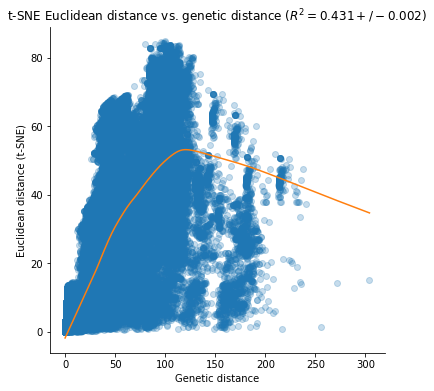

In [10]:
total_df_TSNE = pd.read_csv("results/scatterplot_t-sne.csv",index_col=0)
metadata_TSNE = pd.read_csv("results/scatterplot_t-sne_metadata.csv", index_col=0)

mean = metadata_TSNE["mean"].values.tolist()[0]
std = metadata_TSNE["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (t-SNE)")

ax.set_title(f"t-SNE Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()
#plt.savefig("docs/TSNEScatterplot" + virus_name + ".png")

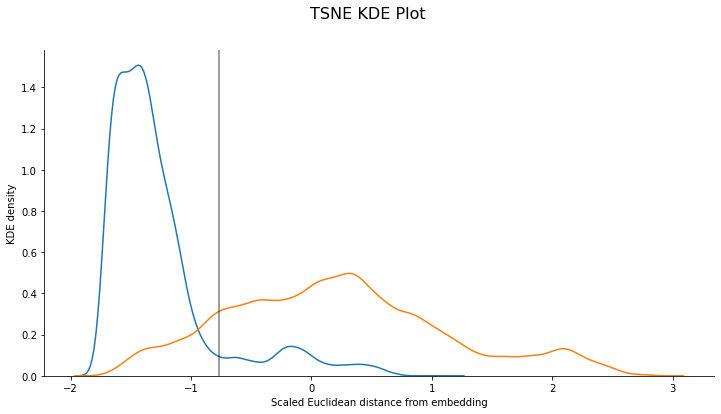

In [23]:
TSNE_KDE_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_t-sne.csv",index_col=0)
TSNE_KDE_metadata_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_t-sne_metadata.csv", index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=TSNE_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('TSNE KDE Plot', fontsize=16)
sns.despine()

# Running UMAP on the Dataset

In [61]:
#principalDf = pd.read_csv(snakemake.input.pca)
UMAP_df = pd.read_csv("results/embed_umap.csv",index_col=0)

In [62]:
merged_umap_df = UMAP_df.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [63]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_brush(
    merged_umap_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'clade_membership',
    ["clade_membership","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]
chart
#chart.save("docs/UMAP" + virus_name + "Brush.html")
#chart.save("docs/UMAP" + virus_name + "Brush.png", scale_factor=2.0)

alt.HConcatChart(...)

# HDBSCAN Output

In [64]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_clickable(
    merged_umap_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'umap_label:N',
    ['umap_label'],
    ["clade_membership","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]
chart
#chart.save("docs/UMAP" + virus_name + "Brush.html")
#chart.save("docs/UMAP" + virus_name + "Brush.png", scale_factor=2.0)

alt.HConcatChart(...)

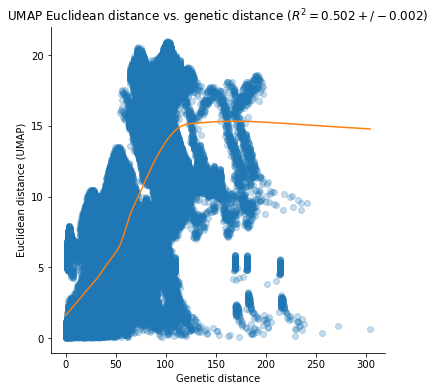

In [11]:
total_df_UMAP = pd.read_csv("results/scatterplot_umap.csv",index_col=0)
metadata_UMAP = pd.read_csv("results/scatterplot_umap_metadata.csv", index_col=0)

mean = metadata_UMAP["mean"].values.tolist()[0]
std = metadata_UMAP["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (UMAP)")

ax.set_title(f"UMAP Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")
sns.despine()
#plt.savefig("docs/UMAPScatterplot" + virus_name + ".png")

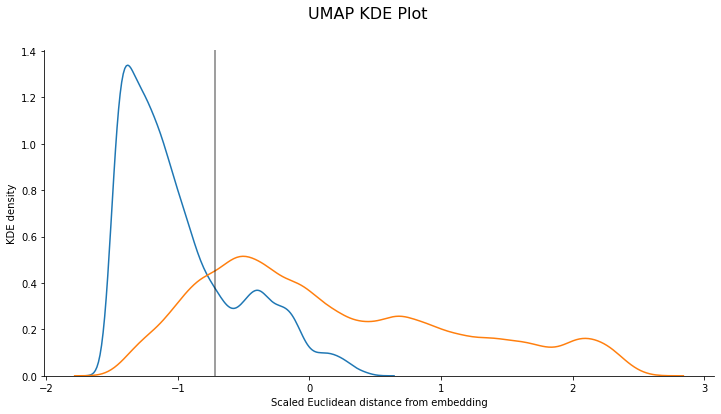

In [24]:
UMAP_KDE_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_umap.csv",index_col=0)
UMAP_KDE_metadata_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_umap_metadata.csv", index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=UMAP_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('UMAP KDE Plot', fontsize=16)
sns.despine()

# Linking all plots together clickable with Tree

In [69]:
merged_df = node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]].merge(
    principalDf,
    on="strain"
).merge(
    MDS_df,
    on="strain"
).merge(
    TSNE_df,
    on="strain"
).merge(
    UMAP_df,
    on="strain"
)

In [70]:
data = linking_tree_with_plots_clickable(
    merged_df,
    ['mds1', 'mds2','tsne_x','tsne_y', 'pca1', 'pca2', 'umap_x','umap_y'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA1 (Expected Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
    'PCA2 (Expected Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",'UMAP1','UMAP2'],
    'clade_membership:N',
    ['clade_membership'],
    ['strain','clade_membership']
)

In [71]:
PCAMDS = data[3]|data[1]|data[5]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.hconcat(data[0],embeddings)
fullChart
fullChart.save("../docs/FullLinkedChartClickable" + "Zika" + ".html")
#fullChart.save("docs/FullLinkedChartClickable" + virus_name + ".svg", scale_factor=2.0)
#drawing = svg2rlg("docs/FullLinkedChartClickable" + virus_name + ".svg")
#renderPDF.drawToFile(drawing, "docs/FullLinkedChartClickable" + virus_name + ".pdf")

In [72]:
fullChart

alt.HConcatChart(...)

## Scatterplots for all embeddings 
Concatenating all embedding data frames to plot genetic vs Euclidean distance for each embedding

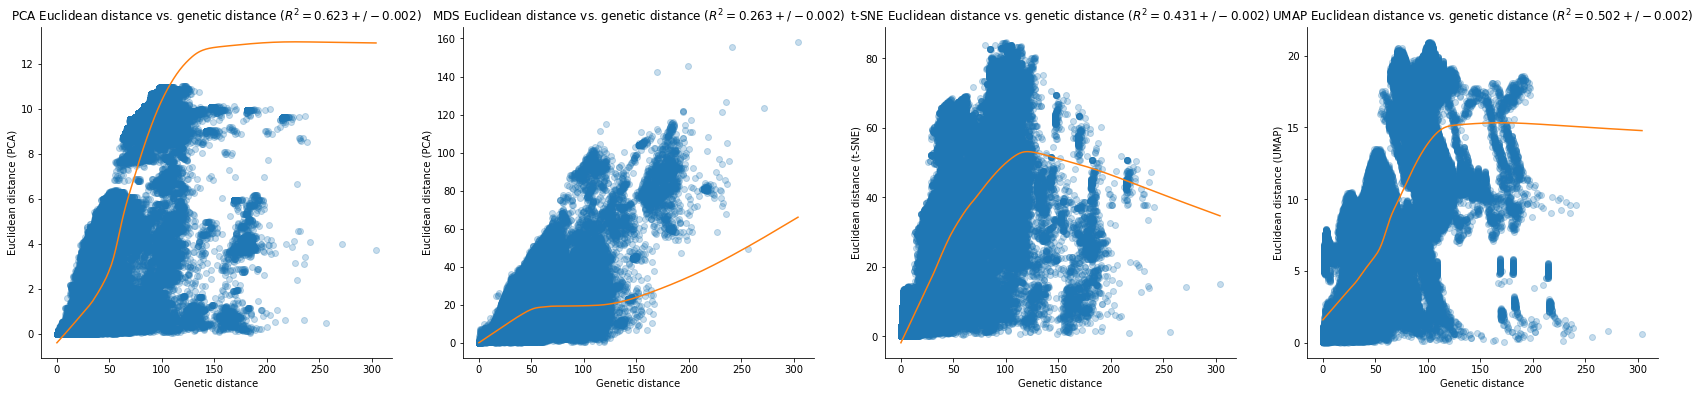

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.tight_layout(pad=4.0)

mean = metadata_PCA["mean"].values.tolist()[0]
std = metadata_PCA["std"].values.tolist()[0]

ax1.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax1.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax1.set_xlabel("Genetic distance")
ax1.set_ylabel("Euclidean distance (PCA)")
ax1.set_title(f"PCA Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_MDS["mean"].values.tolist()[0]
std = metadata_MDS["std"].values.tolist()[0]

ax2.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax2.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax2.set_xlabel("Genetic distance")
ax2.set_ylabel("Euclidean distance (PCA)")
ax2.set_title(f"MDS Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_TSNE["mean"].values.tolist()[0]
std = metadata_TSNE["std"].values.tolist()[0]

ax3.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax3.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax3.set_xlabel("Genetic distance")
ax3.set_ylabel("Euclidean distance (t-SNE)")
ax3.set_title(f"t-SNE Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")



mean = metadata_UMAP["mean"].values.tolist()[0]
std = metadata_UMAP["std"].values.tolist()[0]

ax4.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax4.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax4.set_xlabel("Genetic distance")
ax4.set_ylabel("Euclidean distance (UMAP)")
ax4.set_title(f"UMAP Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


sns.despine()
plt.savefig("../docs/FullScatterplot" + "Zika" + ".png")

## Within- and between-clade Euclidean distances for all embeddings

Use the complete embedding data frame to calculate pairwise Euclidean distances between samples and plot the results in a single figure.

In [18]:
Genetic_KDE_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_genetic.csv",index_col=0)
Genetic_KDE_metadata_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_genetic_metadata.csv", index_col=0)

In [19]:
import matplotlib.gridspec as gridspec

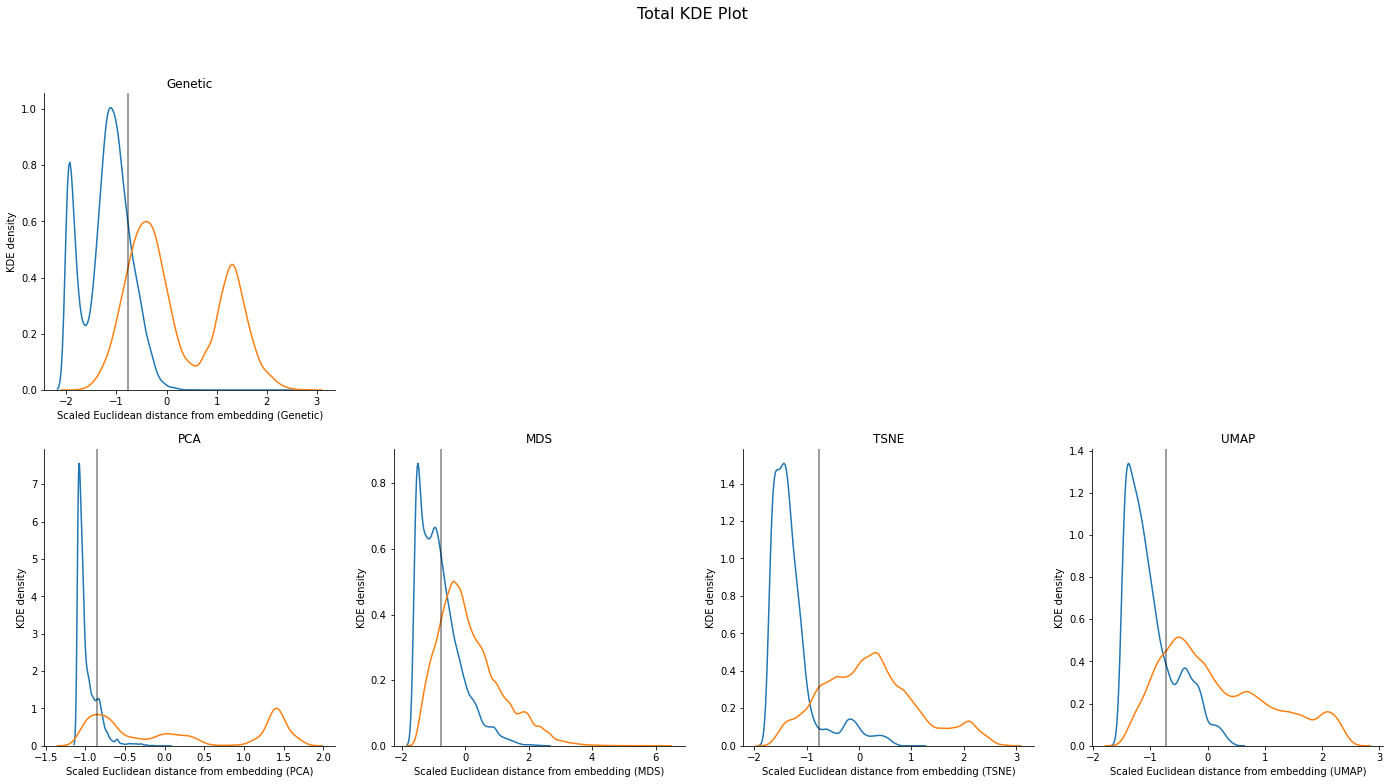

In [26]:
#fig, axes = plt.subplots(1, 5, figsize=(40, 8))
fig = plt.figure(figsize=(24, 12), constrained_layout=False)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2])
ax5 = fig.add_subplot(gs[1, 3])



#GENETIC 
ax1 = sns.kdeplot(Genetic_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax1)
ax1 = sns.kdeplot(Genetic_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax1)
ax1.axvline(x=Genetic_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax1.set_title('Genetic')
ax1.set_xlabel("Scaled Euclidean distance from embedding (Genetic)")
ax1.set_ylabel("KDE density")

#PCA
ax2 = sns.kdeplot(PCA_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax2)
ax2 = sns.kdeplot(PCA_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax2)
ax2.axvline(x=PCA_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax2.set_title('PCA')
ax2.set_xlabel("Scaled Euclidean distance from embedding (PCA)")
ax2.set_ylabel("KDE density")

#MDS
ax3 = sns.kdeplot(MDS_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax3)
ax3 = sns.kdeplot(MDS_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax3)
ax3.axvline(x=MDS_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax3.set_title('MDS')
ax3.set_xlabel("Scaled Euclidean distance from embedding (MDS)")
ax3.set_ylabel("KDE density")

#TSNE
ax4 = sns.kdeplot(TSNE_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax4)
ax4 = sns.kdeplot(TSNE_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax4)
ax4.axvline(x=TSNE_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax4.set_title('TSNE')
ax4.set_xlabel("Scaled Euclidean distance from embedding (TSNE)")
ax4.set_ylabel("KDE density")

#UMAP
ax5 = sns.kdeplot(UMAP_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax5)
ax5 = sns.kdeplot(UMAP_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax5)
ax5.axvline(x=UMAP_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax5.set_title('UMAP')
ax5.set_xlabel("Scaled Euclidean distance from embedding (UMAP)")
ax5.set_ylabel("KDE density")


fig.suptitle('Total KDE Plot', fontsize=16)
sns.despine()
plt.savefig("../docs/FullKDEDensity" + "Zika" + ".png")

# Supplemental Figures

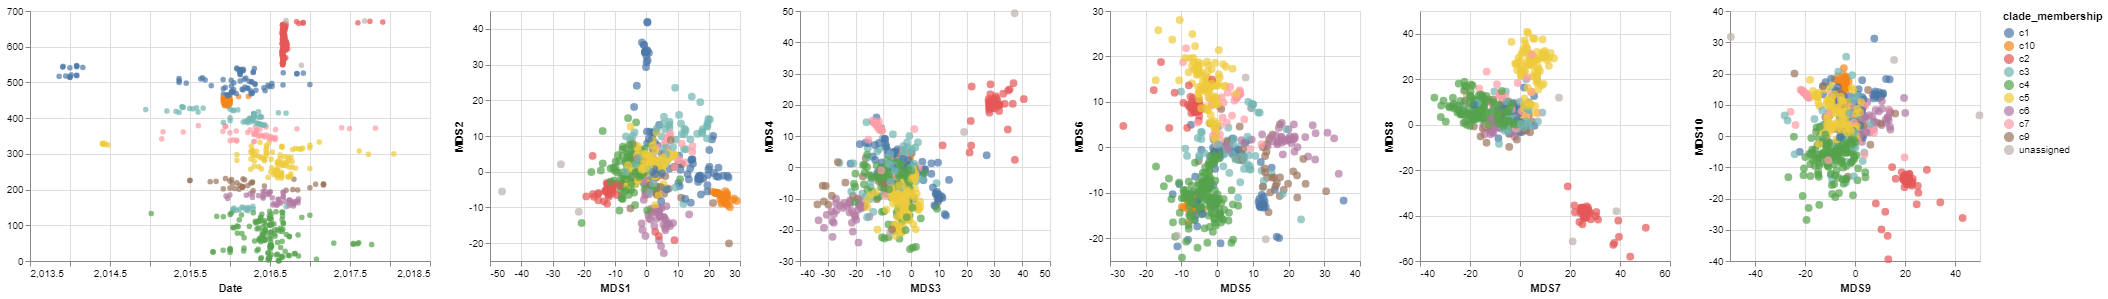

In [116]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds' + str(i) for i in range(1,11)],['MDS' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]|list_of_chart[4]|list_of_chart[5]

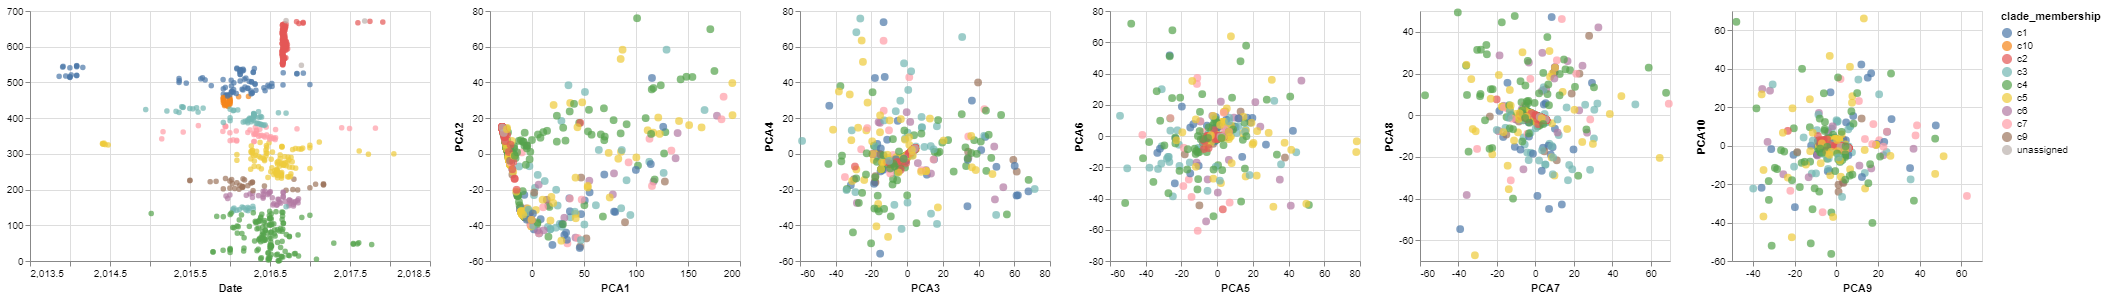

In [117]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca' + str(i) for i in range(1,11)],['PCA' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]|list_of_chart[4]|list_of_chart[5]